In [140]:
from IPython.display import clear_output

!wget http://disk.karelia.pro/arj/8vssiCnyy -O data.csv
!wget http://disk.karelia.pro/qEdiHTK/task1.zip?attachment -O data

!unzip "data"
!unzip "data.csv"
clear_output()

In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
import os
from tqdm.notebook import tqdm
from PIL import Image

class FinalDataset(Dataset):
    def __init__(self, path, df, transform, size=(600, 600)):
        self.transform = transform
      
        filenames = []
        for name, y in df.values:
            filenames.append([os.path.join(path, name),
                              torch.tensor(y).long()])

        self.images = []
        for filename, y in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    image = image.resize(size)
                    self.images.append([image.copy(), y])
            except:
                print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        X = self.transform(img[0])
        return X, img[1]

In [4]:
# size = (128, 128)

# transform_all = transforms.Compose([
#     transforms.RandomResizedCrop(size[0]),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.CenterCrop(size[0]),
#     transforms.RandomVerticalFlip(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                           std=[0.229, 0.224, 0.225])
# ])

In [5]:
size = (256, 256)

transform_all = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
import pandas as pd

df = pd.read_csv("data_600.csv")

In [7]:
df

,index,hockey,people,maсhine,date
0,201902101030.jpg,False,10,False,2019-02-10 10:30:00
1,201902211430.jpg,True,0,False,2019-02-21 14:30:00
2,201902252140.jpg,True,0,False,2019-02-25 21:40:00
3,201902171750.jpg,False,0,True,2019-02-17 17:50:00
4,201901291510.jpg,True,0,False,2019-01-29 15:10:00
...,...,...,...,...,...
595,201902031450.jpg,False,12,False,2019-02-03 14:50:00
596,201902041730.jpg,False,8,False,2019-02-04 17:30:00
597,201901300640.jpg,False,0,False,2019-01-30 06:40:00
598,201902051750.jpg,False,6,False,2019-02-05 17:50:00


In [8]:
temp = df[df["maсhine"]].copy()
temp = temp.append(df[~df["maсhine"]].sample(len(temp) + 10, random_state=42))

In [9]:
temp

,index,hockey,people,maсhine,date
3,201902171750.jpg,False,0,True,2019-02-17 17:50:00
7,201902242220.jpg,False,0,True,2019-02-24 22:20:00
54,201902071850.jpg,False,0,True,2019-02-07 18:50:00
63,201902180940.jpg,False,0,True,2019-02-18 09:40:00
80,201902280750.jpg,False,0,True,2019-02-28 07:50:00
...,...,...,...,...,...
344,201902161150.jpg,False,22,False,2019-02-16 11:50:00
444,201902131330.jpg,True,0,False,2019-02-13 13:30:00
110,201902281640.jpg,True,0,False,2019-02-28 16:40:00
375,201902110900.jpg,False,27,False,2019-02-11 09:00:00


In [10]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(temp[["index", "maсhine"]],
                                      test_size=0.01, random_state=42)

In [11]:
train_dataset = FinalDataset("2019", train_df, transform_all, size=size)
train_dataset = DataLoader(train_dataset, batch_size=64, shuffle=True)

valid_dataset = FinalDataset("2019", valid_df, transform_all, size=size)
valid_dataset = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [12]:
import torchvision.models as models
import random
import numpy as np

# Сидим модель
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Подргружаем модель
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 2)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [13]:
def accuracy(model, val):
    total = 0
    correct = 0
    for X, y in val:
        res = model(X.to(device))
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y.to(device)).sum().item()
    return correct / total

Iterations: 1 Score: 0.0
Iterations: 2 Score: 0.0
Iterations: 3 Score: 0.0
Iterations: 4 Score: 1.0
Iterations: 5 Score: 1.0
Iterations: 6 Score: 1.0
Iterations: 7 Score: 1.0
Iterations: 8 Score: 1.0
Iterations: 9 Score: 1.0
Iterations: 10 Score: 1.0



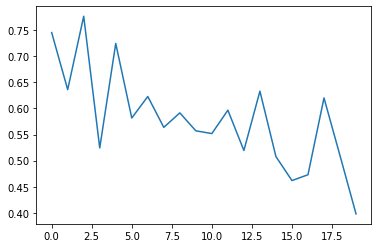

In [14]:
train_losses = []
num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    model.train()
    for X, y in train_dataset:
        optimizer.zero_grad()
        output = model(X.to(device))
        loss = criterion(output, y.to(device))
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()
    model.eval()
    val_score = accuracy(model, valid_dataset)
    print(f"Iterations: {epoch + 1} Score: {val_score}")

plt.plot(train_losses)
plt.show()

In [15]:
model.eval()
accuracy(model, valid_dataset)

1.0

In [16]:
torch.save(model, "network.pth")

In [17]:
len(os.listdir("2019"))

4340

In [18]:
import pandas as pd

df = pd.DataFrame({"dates": pd.to_datetime([i[:-4]
                                            for i in os.listdir("2019")]),
                   "filename": os.listdir("2019")})

In [19]:
transform_all = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def predict_network(network, size, path_,
                    transform, device):
    predictions = []
    for filename in tqdm(os.listdir(path_)):
        with Image.open(os.path.join(path_, filename)) as image:
            image = image.resize(size)
        X = transform(image)
        X = X.view(1, *X.size()).to(device)
        prediction = network(X).argmax(dim=1).item()
        predictions.append([filename, prediction])
    return predictions

In [20]:
pred  = predict_network(model, size, "2019",
                    transform_all, device)

In [21]:
sum(i[1] for i in pred)

553

In [22]:
785 / 4340

0.18087557603686635

2019-02-17 09:40:00


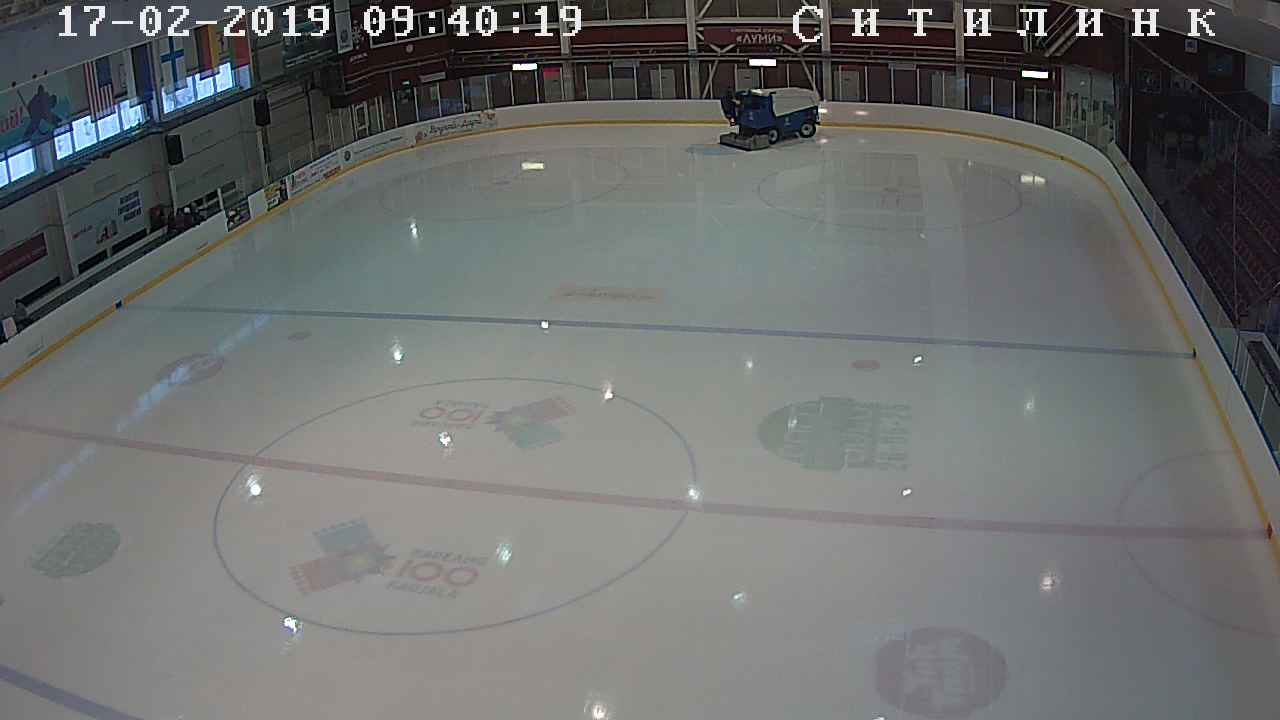

KeyboardInterrupt: ignored

In [23]:
from IPython.display import Image
from IPython.display import display
from IPython.display import clear_output
import os
import time

for name, y in pred:
    print(pd.to_datetime(name[:-4]))
    if y:
        display(Image(f"./2019/{name}"))
        time.sleep(1)
    clear_output()

In [29]:
pd.DataFrame(list(filter(lambda x: x[1], pred)), columns=["name", "pred"])#.to_csv("pred_553.csv")

,name,pred
0,201902242210.jpg,1
1,201902121100.jpg,1
2,201902141050.jpg,1
3,201902191740.jpg,1
4,201902230910.jpg,1
...,...,...
548,201902041250.jpg,1
549,201902031050.jpg,1
550,201902091030.jpg,1
551,201901302300.jpg,1


--2021-04-03 12:47:08--  https://raw.githubusercontent.com/Lednik7/Big-challenges/main/%D0%91%D0%BE%D0%BB%D1%8C%D1%88%D0%B8%D0%B5%20%D0%B2%D1%8B%D0%B7%D0%BE%D0%B2%D1%8B/holidays.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10945 (11K) [text/plain]
Saving to: ‘holidays.csv.1’

holidays.csv.1      100%[===================>]  10.69K  --.-KB/s    in 0s      

2021-04-03 12:47:09 (123 MB/s) - ‘holidays.csv.1’ saved [10945/10945]



In [33]:
pd.read_csv("holidays.csv.1")

,Год/Месяц,Январь,Февраль,Март,Апрель,Май,Июнь,Июль,Август,Сентябрь,Октябрь,Ноябрь,Декабрь,Всего рабочих дней,Всего праздничных и выходных дней,Количество рабочих часов при 40-часовой рабочей неделе,Количество рабочих часов при 36-часовой рабочей неделе,Количество рабочих часов при 24-часовой рабочей неделе
0,1999,"1,2,3,4,6*,7,9,10,16,17,23,24,30,31","6,7,13,14,20,21,27,28","6,7,8,13,14,20,21,27,28","3,4,10,11,17,18,24,25,30*","1,2,3,4,8,9,10,15,16,22,23,29,30","5,6,11*,12,13,14,19,20,26,27","3,4,10,11,17,18,24,25,31","1,7,8,14,15,21,22,28,29","4,5,11,12,18,19,25,26","2,3,9,10,16,17,23,24,30,31","6,7,8,13,14,20,21,27,28","4,5,11,12,13,18,19,25,26,31*",251,114,2004,1807.2,1204.8
1,2000,"1,2,3,4,6*,7,8,9,15,16,22,23,29,30","5,6,12,13,19,20,26,27","4,5,7*,8,11,12,18,19,25,26","1,2,8,9,15,16,22,23,29,30","1,2,6,7,8*,9,13,14,20,21,27,28","3,4,10,11,12,17,18,24,25","1,2,8,9,15,16,22,23,29,30","5,6,12,13,19,20,26,27","2,3,9,10,16,17,23,24,30","1,7,8,14,15,21,22,28,29","4,5,7,11,12,18,19,25,26","2,3,9,10,11*,12,16,17,23,24,30,31",250,116,1995,1800.0,1200.0
2,2001,"1,2,6,7,8,13,14,20,21,27,28","3,4,10,11,17,18,24,25","3,4,7*,8,10,11,17,18,24,25,31","1,7,8,14,15,21,22,28,29,30*","1,2,5,6,8*,9,12,13,19,20,26,27","2,3,9,10,11*,12,16,17,23,24,30","1,7,8,14,15,21,22,28,29","4,5,11,12,18,19,25,26","1,2,8,9,15,16,22,23,29,30","6,7,13,14,20,21,27,28","3,4,6*,7,10,11,17,18,24,25","1,2,8,9,12,15,16,22,23,29,30",251,114,2001,1807.2,1204.8
3,2002,"1,2,5,6,7,12,13,19,20,26,27","2,3,9,10,16,17,22*,23,24,25","2,3,7*,8,9,10,16,17,23,24,30,31","6,7,13,14,20,21,28,30*","1,2,3,4,5,8*,9,10,11,12,19,25,26","1,2,8,9,11*,12,15,16,22,23,29,30","6,7,13,14,20,21,27,28","3,4,10,11,17,18,24,25,31","1,7,8,14,15,21,22,28,29","5,6,12,13,19,20,26,27","2,3,6*,7,8,9,16,17,23,24,30","1,7,8,11*,12,13,14,21,22,28,29,31*",250,115,1992,1792.0,1192.0
4,2003,"1,2,3,5*,6,7,11,12,18,19,25,26","1,2,8,9,15,16,22,23,24","1,2,7*,8,9,10,15,16,22,23,29,30","5,6,12,13,19,20,26,27,30*","1,2,3,4,8*,9,10,11,17,18,24,25,31","1,7,8,11*,12,13,14,15,22,28,29","5,6,12,13,19,20,26,27","2,3,9,10,16,17,23,24,30,31","6,7,13,14,20,21,27,28","4,5,11,12,18,19,25,26","1,2,6*,7,8,9,15,16,22,23,29,30","6,7,11*,12,13,14,20,21,27,28,31*",250,115,1992,1792.0,1192.0
5,2004,"1,2,3,4,6*,7,10,11,17,18,24,25,31","1,7,8,14,15,21,22,23,28,29","6,7,8,13,14,20,21,27,28","3,4,10,11,17,18,24,25,30*","1,2,3,4,8,9,10,15,16,22,23,29,30","5,6,11*,12,13,14,19,20,26,27","3,4,10,11,17,18,24,25,31","1,7,8,14,15,21,22,28,29","4,5,11,12,18,19,25,26","2,3,9,10,16,17,23,24,30,31","6,7,8,13,14,20,21,27,28","4,5,11,12,13,18,19,25,26,31*",251,115,2004,1803.2,1200.8
6,2005,"1,2,3,4,5,6,7,8,9,10,15,16,22,23,29,30","5,6,12,13,19,20,22*,23,26,27","5*,6,7,8,12,13,19,20,26,27","2,3,9,10,16,17,23,24,30","1,2,7,8,9,14,15,21,22,28,29","4,5,11,12,13,18,19,25,26","2,3,9,10,16,17,23,24,30,31","6,7,13,14,20,21,27,28","3,4,10,11,17,18,24,25","1,2,8,9,15,16,22,23,29,30","3*,4,5,6,12,13,19,20,26,27","3,4,10,11,17,18,24,25,31",248,117,1981,1782.6,1187.4
7,2006,"1,2,3,4,5,6,7,8,9,14,15,21,22,28,29","4,5,11,12,18,19,22*,23,24,25","4,5,7*,8,11,12,18,19,25,26","1,2,8,9,15,16,22,23,29,30","1,6*,7,8,9,13,14,20,21,27,28","3,4,10,11,12,17,18,24,25","1,2,8,9,15,16,22,23,29,30","5,6,12,13,19,20,26,27","2,3,9,10,16,17,23,24,30","1,7,8,14,15,21,22,28,29","3*,4,5,6,11,12,18,19,25,26","2,3,9,10,16,17,23,24,30,31",248,117,1981,1782.6,1187.4
8,2007,"1,2,3,4,5,6,7,8,13,14,20,21,27,28","3,4,10,11,17,18,22*,23,24,25","3,4,7*,8,10,11,17,18,24,25,31","1,7,8,14,15,21,22,28*,29,30","1,5,6,8*,9,12,13,19,20,26,27","2,3,9*,10,11,12,16,17,23,24,30","1,7,8,14,15,21,22,28,29","4,5,11,12,18,19,25,26","1,2,8,9,15,16,22,23,29,30","6,7,13,14,20,21,27,28","3,4,5,10,11,17,18,24,25","1,2,8,9,15,16,22,23,29*,30,31",249,116,1986,1786.8,1189.2
9,2008,"1,2,3,4,5,6,7,8,12,13,19,20,26,27","2,3,9,10,16,17,22*,23,24,25","1,2,7*,8,9,10,15,16,22,23,29,30","5,6,12,13,19,20,26,27,30*","1,2,3,8*,9,10,11,17,18,24,25,31","1,8,11*,12,13,14,15,21,22,28,29","5,6,12,13,19,20,26,27","2,3,9,10,16,17,23

In [36]:
import pandas as pd
!wget https://raw.githubusercontent.com/Lednik7/Big-challenges/main/%D0%91%D0%BE%D0%BB%D1%8C%D1%88%D0%B8%D0%B5%20%D0%B2%D1%8B%D0%B7%D0%BE%D0%B2%D1%8B/holidays.csv

holidays = pd.read_csv("holidays.csv.1")
arr = []
for element in holidays.values:
    year = element[0]
    for month, days in enumerate(element[1:13], start=1):
        days = days.replace("*", "").replace("+", "").split(",")
        for day in days:
            arr.append([pd.to_datetime(f"{year}-{month}-{day}"), "Выходные"])

df_holidays = pd.DataFrame(arr, columns=["ds", "holiday"])
df_holidays.head()

,ds,holiday
0,1999-01-01,Выходные
1,1999-01-02,Выходные
2,1999-01-03,Выходные
3,1999-01-04,Выходные
4,1999-01-06,Выходные


In [38]:
df_holidays.to_csv("holidays_all.csv")

In [57]:
import pandas as pd

# формат: "%Y-%m-%d"
# Пример "2015-12-25"
def date_to_range(date: str):
    if type(date) == str:
        date = pd.to_datetime(date)
    dates = [date]
    for _ in range(23):
        date += pd.Timedelta(hours=1)
        dates.append(date)
    return dates

def date_to_week(date: str):
    dates = date_to_range(date)
    date = pd.to_datetime(date)
    for _ in range(6):
        date += pd.Timedelta(days=1)
        for element in date_to_range(date):
            dates.append(element)
    return dates

In [138]:
import random
random.seed(42)

dataset = [[random.choice([True, False]),
            random.randint(0, 46),
            random.choice([False, True])] for _ in range(24 * 7)]

In [151]:
import matplotlib.pyplot as plt

def plot(data: list, figsize=(13, 8)):
    plt.figure(figsize=figsize)
    hockey, people, machine = [], [], []
    for i, element in enumerate(data):
        people.append([element[1]])
        if element[0]:
            hockey.append([i, element[1]])
        if element[2]:
            machine.append([i, element[1]])
    plt.plot(people, label="Люди каждый час")
    plt.scatter([i[0] for i in hockey],
                [i[1] for i in hockey], color="orange", label="Хоккеисты")
    plt.scatter([i[0] for i in machine],
                [i[1] for i in machine], color="red", label="Машина")
    plt.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.6)
    plt.legend()
    plt.show()

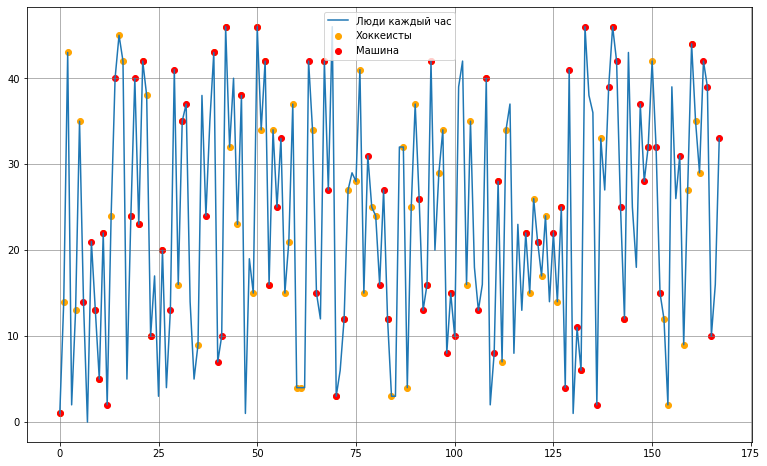

In [152]:
plot(dataset)